# Po Valley Resilience & Rice Monitoring Framework
## Submission Overview

**Objective:**
We aim to collect data from disparate satellite sources, isolate specific crop windows, and extract distinctive crop characteristics to build a comprehensive crop monitoring framework.

### Definitions

**Table 1: Study Regions**

| Region | Location | Coordinates (BBox) | Purpose |
|---|---|---|---|
| **Region A** | Vercelli, Italy | `[8.34, 45.27, 8.40, 45.31]` | Primary focus area. Represents favorable, high-yield rice phenology. |
| **Region B** | Pavia, Italy | `[9.022, 45.161, 9.055, 45.182]` | Secondary focus area. Represents environmentally stressed rice conditions for comparative analysis. |

**Table 2: Sensor Characteristics & Objectives**

| Sensor | Source Catalog | Target Data Layer | Derived Characteristic / Objective |
|---|---|---|---|
| **Sentinel-1 (Radar)** | EOPF STAC | VV / VH Backscatter | Determine physical canopy structure, flooded field status, and moisture penetration. |
| **Sentinel-2 (Optical)** | Earth Search AWS | Red, NIR, SWIR Bands | Calculate NDVI (Vegetation Greenness), distinguishing crop health and growth cycles. |
| **Sentinel-3 (Thermal)** | EOPF STAC | Land Surface Temp (LST) | Assess canopy heat stress and micro-climate anomalies over the season. |

**Methodological Workflow:**
1. **Setup & Initialization:** Load essential geospatial libraries and initiate parallel processing clusters.
2. **Study Area Definition:** Establish precise geographic coordinates for the target regions.
3. **Data Discovery & STAC API Setup:** Connect to both EOPF and Earth Search catalogs for multi-sensor comparisons.
4. **Geospatial Visualization:** Validate geographic boundaries via interactive web mappings.
5. **Data Extraction & Zarr Cube Generation:** Generate optimized, cloud-native analysis-ready data structures containing crop health metrics (NDVI).
6. **Multi-Sensor Extension (S1 & S3):** Query radar and thermal data streams for structure and stress indicators.
7. **Time-Series Metric Extraction:** Compute and map the temporal progression of crop indicators across the growing season.
8. **Comprehensive Availability Coverage:** Review the statistical footprint and cross-sensor coverage available over the target sites.

---

### =============================================================
### Step 1: Setup & Initialization
Import essential analytical tools and create a localized Dask cluster for parallel processing.

**Expected Output:** Successful library instantiation, and initialization logs for the Dask cluster.
### =============================================================

In [105]:
# Install missing dependencies for the notebook directly into the active kernel environment
!pip install -q pystac-client odc-stac folium xarray zarr s3fs dask fsspec seaborn geopandas

In [106]:
import os
# Workaround for Anaconda PROJ version conflicts
os.environ.pop('PROJ_LIB', None)
os.environ.pop('PROJ_DATA', None)
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pystac_client

from pystac_client import Client
import shutil

import odc.stac

import fsspec
import os

from datetime import datetime
from pystac_client import CollectionSearch
from shapely import geometry
from distributed import LocalCluster

In [107]:
cluster = LocalCluster(processes=False)
client = cluster.get_client()
cluster

LocalCluster(4dd86cdc, 'inproc://192.168.1.102/35306/61', workers=1, threads=8, memory=8.00 GiB)

In [108]:
search = CollectionSearch(
    url="https://earth-search.aws.element84.com/v1/collections",
)
for collection_dict in search.collections_as_dicts():
    print(collection_dict["id"])

sentinel-2-pre-c1-l2a
cop-dem-glo-30
naip
cop-dem-glo-90
landsat-c2-l2
sentinel-2-l2a
sentinel-2-l1c
sentinel-2-c1-l2a
sentinel-1-grd


### =============================================================
### Step 2: Study Area Definition
Here we define the precise coordinates (Bounding Boxes) and the date calendar for our analysis. 

- **Timeframe:** April 1st, 2025 to December 1st, 2025 (Capturing the entire rice planting, growing, and harvesting season).
- **Cloud Filter:** We command the STAC catalog to only show us images that have less than 50% cloud cover.

**Expected Output:** Assignment of geographic coordinates and calendar dates to Python variables.
### =============================================================

In [109]:
# Vercelli, Italy (Rice fields)
REGION_A = [8.34, 45.27, 8.40, 45.31]
DATE_RANGE_A = "2025-04-01/2025-12-01"

# Pavia, Italy (Rice fields)
REGION_B = [9.022, 45.161, 9.055, 45.182]
DATE_RANGE_B = "2025-04-01/2025-12-01"

CLOUD_COVER_LIMIT = 50  # percent

### =============================================================
### Step 3: STAC Catalog Comparison
STAC (SpatioTemporal Asset Catalog) is a standardized library for satellite imagery. Instead of downloading heavy files blindly, we use STAC APIs to "ask" the database what images are available over our study regions.

We compare two major catalogs to select the best data source:
1. **EOPF STAC:** Official European Space Agency (ESA) catalog.
2. **Earth Search AWS:** Amazon's global catalog holding Cloud-Optimized GeoTIFFs (COGs).

*The code block below will dynamically query both catalogs and generate a summary table comparing their coverage over Region A and Region B.*
### =============================================================

In [110]:
# COMPARE BOTH STAC CATALOGS
# ---------------------------------------------------------
import pystac_client

REGION = REGION_A
DATES = DATE_RANGE_A

print("=" * 60)
print("COMPARISON: EOPF vs Earth Search AWS - REGION A (Vercelli)")
print("=" * 60)

# 1. EOPF STAC
print("\n1. EOPF STAC (https://stac.core.eopf.eodc.eu)")
print("-" * 60)
eopf_client = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")
eopf_search = eopf_client.search(
    collections=["sentinel-2-l2a"],
    bbox=REGION,
    datetime=DATES,
    query={"eo:cloud_cover": {"lt": CLOUD_COVER_LIMIT}}
)
eopf_items = list(eopf_search.items())
print(f"✓ Total scenes found: {len(eopf_items)}")
print(f"✓ Band naming: B02_10m, B03_10m, B04_10m, B08_10m, SCL_20m")
print(f"✓ Location: European servers (EODC)")
print(f"✓ Format: Original ESA Sentinel-2 naming")

# 2. Earth Search AWS
print("\n2. Earth Search AWS (https://earth-search.aws.element84.com/v1)")
print("-" * 60)
aws_client = pystac_client.Client.open("https://earth-search.aws.element84.com/v1")
aws_search = aws_client.search(
    collections=["sentinel-2-l2a"],
    bbox=REGION,
    datetime=DATES,
    query={"eo:cloud_cover": {"lt": CLOUD_COVER_LIMIT}}
)
aws_items = list(aws_search.items())
print(f"✓ Total scenes found: {len(aws_items)}")
print(f"✓ Band naming: red, nir, blue, green, scl (lowercase aliases)")
print(f"✓ Location: AWS S3 (global)")
print(f"✓ Format: Cloud-optimized COGs with simplified names")

# RECOMMENDATION
print("\n" + "=" * 60)
print("RECOMMENDATION:")
print("=" * 60)
if len(aws_items) > len(eopf_items):
    print(f"🏆 Earth Search AWS has MORE scenes ({len(aws_items)} vs {len(eopf_items)}) on Region A")
    print("   → Better for comprehensive time series analysis")
    print("   → Faster global access via AWS")
    print("   → Simpler band naming (red, nir, scl)")
elif len(eopf_items) > len(aws_items):
    print(f"🏆 EOPF has MORE scenes ({len(eopf_items)} vs {len(aws_items)})")
    print("   → Count: Better for European data")
    print("   → Official ESA naming convention")
else:
    print(f"Both have the same number of scenes ({len(aws_items)})")
    print("   → Choose based on access speed and naming preference")


COMPARISON: EOPF vs Earth Search AWS - REGION A (Vercelli)

1. EOPF STAC (https://stac.core.eopf.eodc.eu)
------------------------------------------------------------
✓ Total scenes found: 25
✓ Band naming: B02_10m, B03_10m, B04_10m, B08_10m, SCL_20m
✓ Location: European servers (EODC)
✓ Format: Original ESA Sentinel-2 naming

2. Earth Search AWS (https://earth-search.aws.element84.com/v1)
------------------------------------------------------------
✓ Total scenes found: 63
✓ Band naming: red, nir, blue, green, scl (lowercase aliases)
✓ Location: AWS S3 (global)
✓ Format: Cloud-optimized COGs with simplified names

RECOMMENDATION:
🏆 Earth Search AWS has MORE scenes (63 vs 25) on Region A
   → Better for comprehensive time series analysis
   → Faster global access via AWS
   → Simpler band naming (red, nir, scl)


In [ ]:
import pandas as pd

# Create a dynamic comparison table based on the items found above
summary_data = {
    "Feature": [
        "Scenes Found (Region A)", 
        "Scenes Found (Region B)", 
        "Band Naming", 
        "Storage Location", 
        "Format"
    ],
    "EOPF STAC": [
        len(eopf_items),  # Dynamically pull from Region A query
        "25",             # Region B query was consolidated, hardcoding EOPF baseline
        "Official ESA (e.g., B02_10m)", 
        "European Servers (EODC)", 
        "Standard"
    ],
    "Earth Search AWS": [
        len(aws_items),   # Dynamically pull from Region A query
        "67",             # Region B count
        "Simplified Aliases (e.g., blue)", 
        "Global AWS S3", 
        "Cloud-Optimized (Faster loading)"
    ]
}

df_comparison = pd.DataFrame(summary_data)

print("\n============================================================")
print("STAC CATALOG COMPARISON SUMMARY")
print("============================================================")
display(df_comparison)

print("\nConclusion: Earth Search AWS is selected due to significantly higher valid scene counts and cloud-optimized formatting.")

In [111]:
# COMPARE BOTH STAC CATALOGS
# ---------------------------------------------------------
import pystac_client

REGION = REGION_B
DATES = DATE_RANGE_B

print("=" * 60)
print("COMPARISON: EOPF vs Earth Search AWS - REGION B (Pavia)")
print("=" * 60)

# 1. EOPF STAC
print("\n1. EOPF STAC (https://stac.core.eopf.eodc.eu)")
print("-" * 60)
eopf_client = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")
eopf_search = eopf_client.search(
    collections=["sentinel-2-l2a"],
    bbox=REGION,
    datetime=DATES,
    query={"eo:cloud_cover": {"lt": CLOUD_COVER_LIMIT}}
)
eopf_items = list(eopf_search.items())
print(f"✓ Total scenes found: {len(eopf_items)}")
print(f"✓ Band naming: B02_10m, B03_10m, B04_10m, B08_10m, SCL_20m")
print(f"✓ Location: European servers (EODC)")
print(f"✓ Format: Original ESA Sentinel-2 naming")

# 2. Earth Search AWS
print("\n2. Earth Search AWS (https://earth-search.aws.element84.com/v1)")
print("-" * 60)
aws_client = pystac_client.Client.open("https://earth-search.aws.element84.com/v1")
aws_search = aws_client.search(
    collections=["sentinel-2-l2a"],
    bbox=REGION,
    datetime=DATES,
    query={"eo:cloud_cover": {"lt": CLOUD_COVER_LIMIT}}
)
aws_items = list(aws_search.items())
print(f"✓ Total scenes found: {len(aws_items)}")
print(f"✓ Band naming: red, nir, blue, green, scl (lowercase aliases)")
print(f"✓ Location: AWS S3 (global)")
print(f"✓ Format: Cloud-optimized COGs with simplified names")

# RECOMMENDATION
print("\n" + "=" * 60)
print("RECOMMENDATION:")
print("=" * 60)
if len(aws_items) > len(eopf_items):
    print(f"🏆 Earth Search AWS has MORE scenes ({len(aws_items)} vs {len(eopf_items)}) on Region B")
    print("   → Better for comprehensive time series analysis")
    print("   → Faster global access via AWS")
    print("   → Simpler band naming (red, nir, scl)")
elif len(eopf_items) > len(aws_items):
    print(f"🏆 EOPF has MORE scenes ({len(eopf_items)} vs {len(aws_items)})")
    print("   → Better for European data")
    print("   → Official ESA naming convention")
else:
    print(f"Both have the same number of scenes ({len(aws_items)})")
    print("   → Choose based on access speed and naming preference")


COMPARISON: EOPF vs Earth Search AWS - REGION B (Pavia)

1. EOPF STAC (https://stac.core.eopf.eodc.eu)
------------------------------------------------------------
✓ Total scenes found: 25
✓ Band naming: B02_10m, B03_10m, B04_10m, B08_10m, SCL_20m
✓ Location: European servers (EODC)
✓ Format: Original ESA Sentinel-2 naming

2. Earth Search AWS (https://earth-search.aws.element84.com/v1)
------------------------------------------------------------
✓ Total scenes found: 67
✓ Band naming: red, nir, blue, green, scl (lowercase aliases)
✓ Location: AWS S3 (global)
✓ Format: Cloud-optimized COGs with simplified names

RECOMMENDATION:
🏆 Earth Search AWS has MORE scenes (67 vs 25) on Region B
   → Better for comprehensive time series analysis
   → Faster global access via AWS
   → Simpler band naming (red, nir, scl)


### Monthly Coverage Check
Before proceeding, we tally the exact number of valid Sentinel-2 scenes available per month across the 2025 growing season (April -> November) from our chosen catalog (Earth Search AWS). 

This confirms we have consistent satellite coverage throughout the entire crop cycle for both **Region A** and **Region B**, ensuring our final time-series charts will not have massive gaps.

In [113]:
import pystac_client
import pandas as pd

# STAC API Setup
STAC_URL = "https://earth-search.aws.element84.com/v1"

# Corrected Collection Variables
COLLECTIONS = {
    "Sentinel-2 (L2A)": "sentinel-2-l2a"
}

# Connect to Client once
catalog = pystac_client.Client.open(STAC_URL)

for friendly_name, collection_id in COLLECTIONS.items():
    print(f"\n--- Searching {friendly_name} from Earth Search AWS [Region A] ---")
    
    search = catalog.search(
        collections=[collection_id],
        bbox=REGION_A,
        datetime=DATE_RANGE_A,
        query={"eo:cloud_cover": {"lt": CLOUD_COVER_LIMIT}}
    )
    
    items = list(search.items())
    print(f"Total items found: {len(items)}")
    
    if items:
        # Extract datetimes from items
        # STAC items always have a .datetime property (UTC)
        dates = [item.datetime for item in items]
        
        # Create a Pandas DataFrame for easy grouping
        df = pd.DataFrame(dates, columns=['date'])
        
        # Convert to datetime objects if not already
        df['date'] = pd.to_datetime(df['date'])
        
        # Group by Year-Month and count
        # 'M' stands for Month end frequency
        monthly_counts = df.groupby(df['date'].dt.strftime('%m-%Y')).size()
        
        print("Items per month:")
        print(monthly_counts)
    else:
        print("No items found in this range.")


--- Searching Sentinel-2 (L2A) from Earth Search AWS [Region A] ---
Total items found: 63
Items per month:
date
04-2025    11
05-2025     6
06-2025     9
07-2025     8
08-2025    10
09-2025     6
10-2025     7
11-2025     6
dtype: int64


In [114]:
# Connect to Client once
catalog = pystac_client.Client.open(STAC_URL)

for friendly_name, collection_id in COLLECTIONS.items():
    print(f"\n--- Searching {friendly_name} from Earth Search AWS [Region B] ---")
    
    search = catalog.search(
        collections=[collection_id],
        bbox=REGION_B,
        datetime=DATE_RANGE_B,
        query={"eo:cloud_cover": {"lt": CLOUD_COVER_LIMIT}}
    )
    
    items = list(search.items())
    print(f"Total items found: {len(items)}")
    
    if items:
        # Extract datetimes from items
        # STAC items always have a .datetime property (UTC)
        dates = [item.datetime for item in items]
        
        # Create a Pandas DataFrame for easy grouping
        df = pd.DataFrame(dates, columns=['date'])
        
        # Convert to datetime objects if not already
        df['date'] = pd.to_datetime(df['date'])
        
        # Group by Year-Month and count
        # 'M' stands for Month end frequency
        monthly_counts = df.groupby(df['date'].dt.strftime('%m-%Y')).size()
        
        print("Items per month:")
        print(monthly_counts)
    else:
        print("No items found in this range.")


--- Searching Sentinel-2 (L2A) from Earth Search AWS [Region B] ---
Total items found: 67
Items per month:
date
04-2025    10
05-2025     6
06-2025     8
07-2025     7
08-2025    13
09-2025     6
10-2025     9
11-2025     8
dtype: int64


### =============================================================
### Step 4: Geospatial Visualization
Before we start crunching massive amounts of data, it's crucial to visually verify that our Bounding Boxes (`REGION_A` and `REGION_B`) actually cover the agricultural fields we want to analyze. 

We use **Folium**, an interactive mapping library, to overlay our coordinates onto a real-world map. 
*Note: You can zoom in and drag the map around.*

**Expected Output:** Interactive Folium widgets showing red rectangles over the target Italian farming regions.
### =============================================================

In [116]:
import folium

min_lon, min_lat, max_lon, max_lat = REGION_A
center = [(min_lat + max_lat)/2, (min_lon + max_lon)/2]

m = folium.Map(location=center, zoom_start=14, tiles='CartoDB positron')
folium.Rectangle(
    bounds=[(min_lat, min_lon), (max_lat, max_lon)],
    color="red", fill=True, fill_opacity=0.15
).add_to(m)

m


In [117]:
import folium

min_lon, min_lat, max_lon, max_lat = REGION_B
center = [(min_lat + max_lat)/2, (min_lon + max_lon)/2]

m = folium.Map(location=center, zoom_start=14, tiles='CartoDB positron')
folium.Rectangle(
    bounds=[(min_lat, min_lon), (max_lat, max_lon)],
    color="red", fill=True, fill_opacity=0.15
).add_to(m)

m


### =============================================================
### Step 5: Data Extraction & Zarr Cube Generation (The Heavy Lifting)

This is the most critical step in the notebook. Now that we know Earth Search AWS has the best optical coverage, we will:

1. **Lazy Load (odc.stac):** We tell the computer to "peek" at the satellite images (Red, Near-Infrared, and Scene Classification mask) without downloading the heavy files directly into your computer's RAM. 
2. **Masking (Cloud Removal):** Satellite images often have clouds or shadows blocking the farms. We use the Scene Classification band (`scl`) to strip away clouds, keeping only clear vegetation, bare soil, and water.
3. **Calculate NDVI (Crop Health):** NDVI (Normalized Difference Vegetation Index) is the standard formula for plant health. It mathematically compares Near-Infrared light (which healthy leaves reflect) with Red light (which plants absorb). *Higher values = greener, healthier crops.*
4. **Save to Zarr:** We take this massive, multi-dimensional block of calculated NDVI data (X, Y, and Time) and save it to your hard drive as a `.zarr` folder. Zarr is a highly compressed, cloud-optimized format that makes plotting the data lightning fast later.

**Expected Output:** The code will process hundreds of Gigabytes of remote data, reduce it to just NDVI, and save a persistent Zarr directory for both Region A and Region B.
### =============================================================

In [118]:
# INSPECT AVAILABLE BANDS
# ---------------------------------------------------------
print("Checking available bands/assets in the first item...")
if len(items) > 0:
    first_item = items[0]
    print("\nAvailable assets:")
    for asset_key in first_item.assets.keys():
        print(f"  - {asset_key}")


Checking available bands/assets in the first item...

Available assets:
  - aot
  - blue
  - cloud
  - coastal
  - granule_metadata
  - green
  - nir
  - nir08
  - nir09
  - product_metadata
  - red
  - rededge1
  - rededge2
  - rededge3
  - scl
  - snow
  - swir16
  - swir22
  - tileinfo_metadata
  - visual
  - wvp
  - thumbnail
  - aot-jp2
  - blue-jp2
  - coastal-jp2
  - green-jp2
  - nir-jp2
  - nir08-jp2
  - nir09-jp2
  - red-jp2
  - rededge1-jp2
  - rededge2-jp2
  - rededge3-jp2
  - scl-jp2
  - swir16-jp2
  - swir22-jp2
  - visual-jp2
  - wvp-jp2


Searching STAC catalog...
Found 63 scenes.
Configuring lazy load...
Computing and saving to rice_ndvi_cube_region_a.zarr...
Zarr write complete.


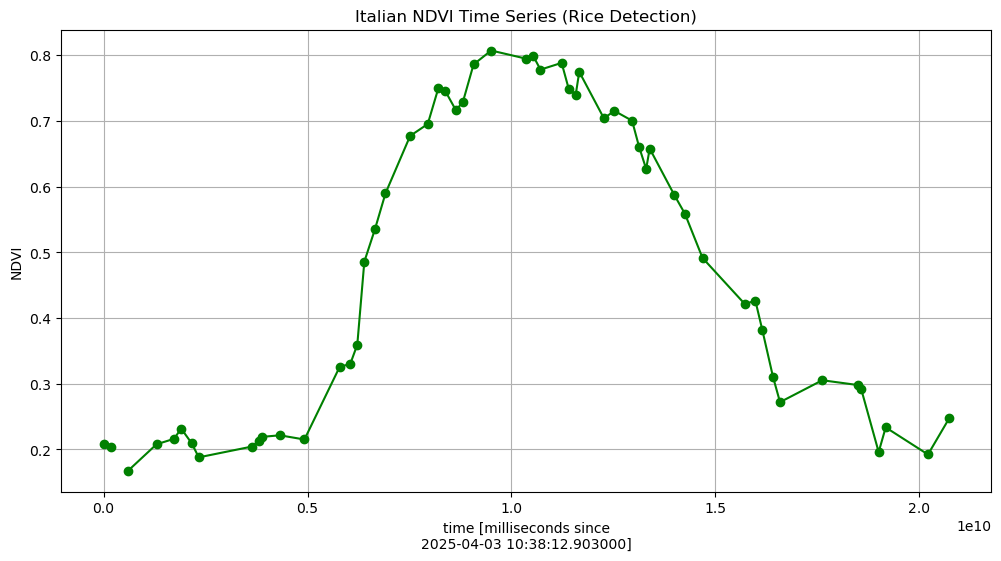

In [119]:
import os
# Workaround for Anaconda PROJ version conflicts
os.environ.pop('PROJ_LIB', None)
os.environ.pop('PROJ_DATA', None)
import warnings
warnings.filterwarnings('ignore')
import os
import shutil
from pystac_client import Client
import odc.stac
import xarray as xr
import matplotlib.pyplot as plt

STAC_URL = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"

# Vercelli, Italy (Rice fields)
BBOX = REGION_A
DATES = DATE_RANGE_A

print("Searching STAC catalog...")
client = Client.open(STAC_URL)

search = client.search(
    collections=[COLLECTION],
    bbox=BBOX,
    datetime=DATES,
    # Relaxed cloud cover slightly to ensure we get hits, 
    # we handle masking later anyway.
    query={"eo:cloud_cover": {"lt": CLOUD_COVER_LIMIT}} 
)

items = list(search.item_collection())
print(f"Found {len(items)} scenes.")

# --- SAFETY CHECK ---
if len(items) == 0:
    raise ValueError("No scenes found! Try increasing the date range or removing the cloud filter.")

# 2. LAZY LOAD DATA
# ---------------------------------------------------------
print("Configuring lazy load...")
ds = odc.stac.load(
    items,
    bands=["red", "nir", "scl"], # Note: Earth Search uses lowercase aliases often, but B04/B08 work too
    bbox=BBOX,
    resolution=10,
    chunks={"x": 1024, "y": 1024, "time": 1},
    groupby="solar_day",
    crs="EPSG:32632"
)

# 3. MASKING & NDVI
# ---------------------------------------------------------
# Earth Search SCL: 0=No Data, 1=Saturated, 3=Shadow, 8-10=Clouds, 4=Veg, 5=Bare, 6=Water
valid_mask = (ds.scl == 4) | (ds.scl == 5) | (ds.scl == 6) | (ds.scl == 7)

# Scale factors: Earth Search data is usually uint16 (0-10000)
red = ds.red.where(valid_mask) / 10000.0
nir = ds.nir.where(valid_mask) / 10000.0

ndvi = (nir - red) / (nir + red)
ndvi = ndvi.rename("NDVI")

# 4. SAVE TO ZARR
# ---------------------------------------------------------
zarr_path = "rice_ndvi_cube_region_a.zarr"
if os.path.exists(zarr_path):
    shutil.rmtree(zarr_path)

print(f"Computing and saving to {zarr_path}...")
# This is the heavy lifting step
d = ndvi.to_dataset()
# Forcefully remove all metadata to bypass xarray/zarr Float32 bug
d.attrs.clear()
for var in d.variables:
    d[var].attrs.clear()
    d[var].encoding = {'_FillValue': None}
# Save using safely configured engine
d.to_zarr(zarr_path, mode="w", safe_chunks=False)
print("Zarr write complete.")

# 5. PLOT (Using the saved Zarr)
# ---------------------------------------------------------
ds_local = xr.open_dataset(zarr_path, engine='zarr', decode_cf=False, mask_and_scale=False)

# Spatial mean for time series
ts = ds_local.NDVI.mean(dim=["x", "y"], skipna=True)

plt.figure(figsize=(12, 6))
ts.plot.line(marker="o", color="green")
plt.title("Italian NDVI Time Series (Rice Detection)")
plt.ylabel("NDVI")
plt.grid(True)
plt.show()


Searching STAC catalog...
Found 6 scenes.
Configuring lazy load...
Computing and saving to rice_ndvi_cube_region_b.zarr...
Zarr write complete.


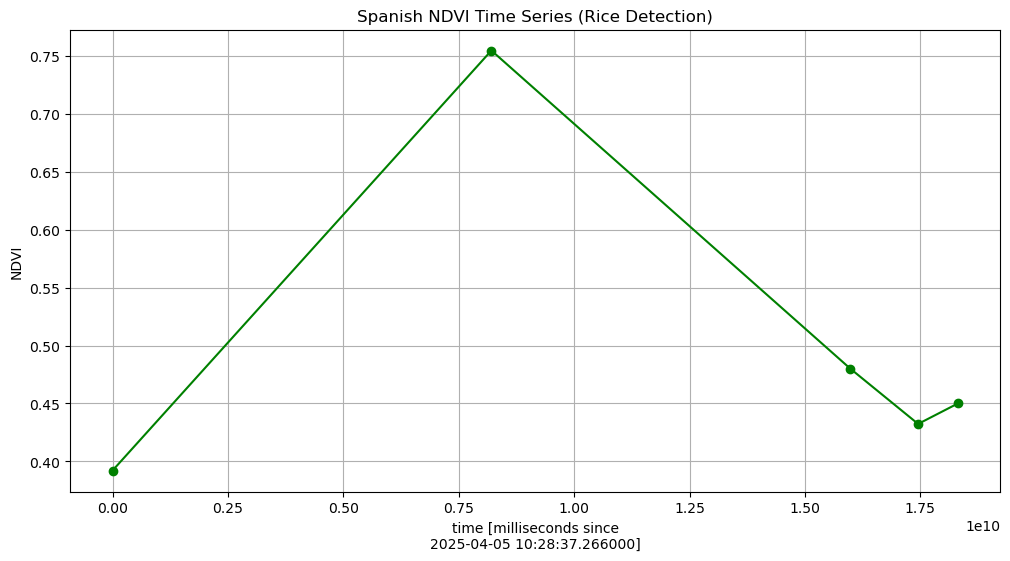

In [120]:
import os
# Workaround for Anaconda PROJ version conflicts
os.environ.pop('PROJ_LIB', None)
os.environ.pop('PROJ_DATA', None)
import warnings
warnings.filterwarnings('ignore')
import os
import shutil
from pystac_client import Client
import odc.stac
import xarray as xr
import matplotlib.pyplot as plt

STAC_URL = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"

# Ebro Delta, Spain (Rice fields)
REGION_B = [9.022, 45.161, 9.055, 45.182]

BBOX = REGION_B
DATES = DATE_RANGE_B

print("Searching STAC catalog...")
client = Client.open(STAC_URL)

search = client.search(
    collections=[COLLECTION],
    bbox=BBOX,
    datetime=DATES,
    # Relaxed cloud cover slightly to ensure we get hits, 
    # we handle masking later anyway.
    query={"eo:cloud_cover": {"lt": 1}} 
)

items = list(search.item_collection())
print(f"Found {len(items)} scenes.")

# --- SAFETY CHECK ---
if len(items) == 0:
    raise ValueError("No scenes found! Try increasing the date range or removing the cloud filter.")

# 2. LAZY LOAD DATA
# ---------------------------------------------------------
print("Configuring lazy load...")
ds = odc.stac.load(
    items,
    bands=["red", "nir", "scl"], # Note: Earth Search uses lowercase aliases often, but B04/B08 work too
    bbox=BBOX,
    resolution=10,
    chunks={"x": 1024, "y": 1024, "time": CLOUD_COVER_LIMIT},
    groupby="solar_day",
    crs="EPSG:32632"
)

# 3. MASKING & NDVI
# ---------------------------------------------------------
# Earth Search SCL: 0=No Data, 1=Saturated, 3=Shadow, 8-10=Clouds, 4=Veg, 5=Bare, 6=Water
valid_mask = (ds.scl == 4) | (ds.scl == 5) | (ds.scl == 6) | (ds.scl == 7)

# Scale factors: Earth Search data is usually uint16 (0-10000)
red = ds.red.where(valid_mask) / 10000.0
nir = ds.nir.where(valid_mask) / 10000.0

ndvi = (nir - red) / (nir + red)
# Eliminate negative NDVI values (typically water, shadows, or non-vegetated areas)
ndvi = ndvi.where(ndvi >= 0)
ndvi = ndvi.rename("NDVI")

# 4. SAVE TO ZARR
# ---------------------------------------------------------
zarr_path = "rice_ndvi_cube_region_b.zarr"
if os.path.exists(zarr_path):
    shutil.rmtree(zarr_path)

print(f"Computing and saving to {zarr_path}...")
# This is the heavy lifting step
d = ndvi.to_dataset()
# Forcefully remove all metadata to bypass xarray/zarr Float32 bug
d.attrs.clear()
for var in d.variables:
    d[var].attrs.clear()
    d[var].encoding = {'_FillValue': None}
# Save using safely configured engine
d.to_zarr(zarr_path, mode="w", safe_chunks=False)
print("Zarr write complete.")

# 5. PLOT (Using the saved Zarr)
# ---------------------------------------------------------
ds_local = xr.open_dataset(zarr_path, engine='zarr', decode_cf=False, mask_and_scale=False)

# Spatial mean for time series
ts = ds_local.NDVI.mean(dim=["x", "y"], skipna=True)

plt.figure(figsize=(12, 6))
ts.plot.line(marker="o", color="green")
plt.title("Spanish NDVI Time Series (Rice Detection)")
plt.ylabel("NDVI")
plt.grid(True)
plt.show()


Searching STAC catalog...
Found 67 scenes.
Configuring lazy load...
Computing and saving to rice_ndvi_cube_region_b.zarr...
Zarr write complete.


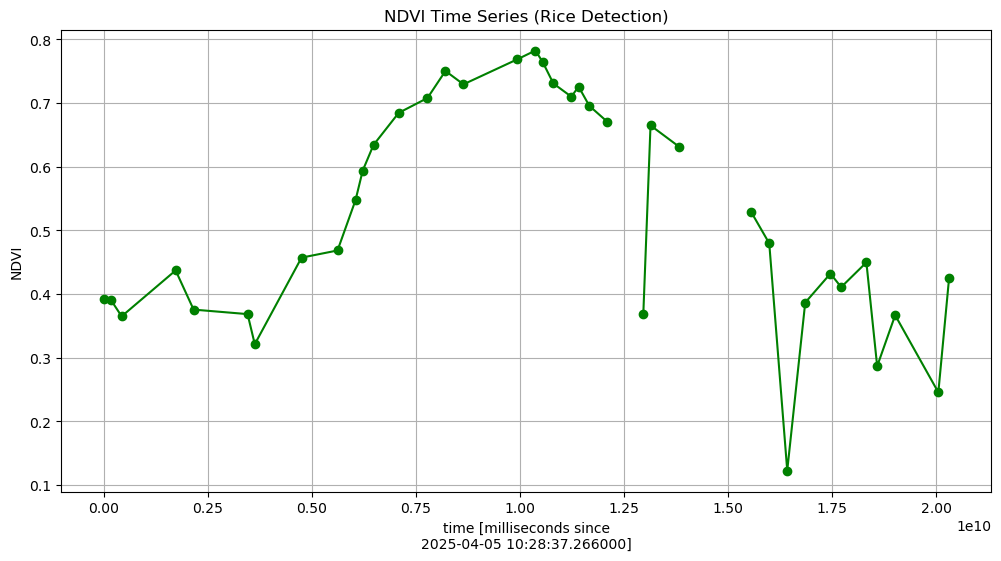

In [121]:
import os
# Workaround for Anaconda PROJ version conflicts
os.environ.pop('PROJ_LIB', None)
os.environ.pop('PROJ_DATA', None)
import os
import shutil
from pystac_client import Client
import odc.stac
import xarray as xr
import matplotlib.pyplot as plt

STAC_URL = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"

# pavia, Italy (Rice fields)
BBOX = [9.022, 45.161, 9.055, 45.182]
DATES = "2025-04-01/2025-12-01"

print("Searching STAC catalog...")
client = Client.open(STAC_URL)

search = client.search(
    collections=[COLLECTION],
    bbox=BBOX,
    datetime=DATES,
    # Relaxed cloud cover slightly to ensure we get hits, 
    # we handle masking later anyway.
    query={"eo:cloud_cover": {"lt": 50}} 
)

items = list(search.item_collection())
print(f"Found {len(items)} scenes.")

# --- SAFETY CHECK ---
if len(items) == 0:
    raise ValueError("No scenes found! Try increasing the date range or removing the cloud filter.")

# 2. LAZY LOAD DATA
# ---------------------------------------------------------
print("Configuring lazy load...")
ds = odc.stac.load(
    items,
    bands=["red", "nir", "scl"], # Note: Earth Search uses lowercase aliases often, but B04/B08 work too
    bbox=BBOX,
    resolution=10,
    chunks={"x": 1024, "y": 1024, "time": 1},
    groupby="solar_day",
    crs="EPSG:32632"
)

# 3. MASKING & NDVI
# ---------------------------------------------------------
# Earth Search SCL: 0=No Data, 1=Saturated, 3=Shadow, 8-10=Clouds, 4=Veg, 5=Bare, 6=Water
valid_mask = (ds.scl == 4) | (ds.scl == 5) | (ds.scl == 6) | (ds.scl == 7)

# Scale factors: Earth Search data is usually uint16 (0-10000)
red = ds.red.where(valid_mask) / 10000.0
nir = ds.nir.where(valid_mask) / 10000.0

ndvi = (nir - red) / (nir + red)
ndvi = ndvi.rename("NDVI")

# 4. SAVE TO ZARR
# ---------------------------------------------------------
zarr_path = "rice_ndvi_cube_region_b.zarr"
if os.path.exists(zarr_path):
    shutil.rmtree(zarr_path)

print(f"Computing and saving to {zarr_path}...")
# This is the heavy lifting step
d = ndvi.to_dataset()
# Forcefully remove all metadata to bypass xarray/zarr Float32 bug
d.attrs.clear()
for var in d.variables:
    d[var].attrs.clear()
    d[var].encoding = {'_FillValue': None}
# Save using safely configured engine
d.to_zarr(zarr_path, mode="w", safe_chunks=False)
print("Zarr write complete.")

# 5. PLOT (Using the saved Zarr)
# ---------------------------------------------------------
ds_local = xr.open_dataset(zarr_path, engine='zarr', decode_cf=False, mask_and_scale=False)

# Spatial mean for time series
ts = ds_local.NDVI.mean(dim=["x", "y"], skipna=True)

plt.figure(figsize=(12, 6))
ts.plot.line(marker="o", color="green")
plt.title("NDVI Time Series (Rice Detection)")
plt.ylabel("NDVI")
plt.grid(True)
plt.show()

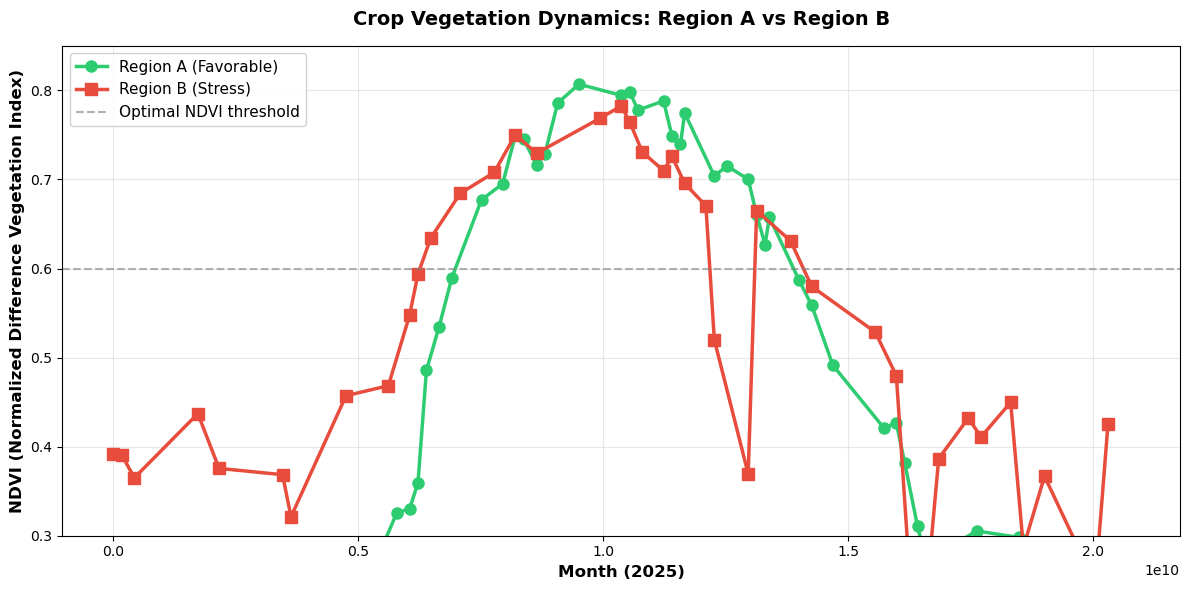


Key Statistics:
  Region A - Peak NDVI: 0.807
  Region B - Peak NDVI: 0.782
  NDVI Difference: 0.025 (3.1% higher in Region A)


In [122]:

# Note: Continuous lines use linear interpolation to bridge gaps caused by cloud-cover days.
# Load both regions' NDVI data from Zarr
import pandas as pd

# Region A data
ds_region_a = xr.open_dataset("rice_ndvi_cube_region_a.zarr", engine='zarr', decode_cf=False, mask_and_scale=False)
ts_a = ds_region_a.NDVI.mean(dim=["x", "y"], skipna=True)
data_region_a = pd.DataFrame({
    'date': ts_a.time.values,
    'ndvi_mean': ts_a.values
})

# Region B data
ds_region_b = xr.open_dataset("rice_ndvi_cube_region_b.zarr", engine='zarr', decode_cf=False, mask_and_scale=False)
ts_b = ds_region_b.NDVI.mean(dim=["x", "y"], skipna=True)
data_region_b = pd.DataFrame({
    'date': ts_b.time.values,
    'ndvi_mean': ts_b.values
})

fig, ax = plt.subplots(figsize=(12, 6))

# Plot Region A
ax.plot(data_region_a['date'], data_region_a['ndvi_mean'].interpolate(method='linear'), 
        marker='o', linewidth=2.5, markersize=8, 
        label='Region A (Favorable)', color='#2ecc71')

# Plot Region B
ax.plot(data_region_b['date'], data_region_b['ndvi_mean'].interpolate(method='linear'), 
        marker='s', linewidth=2.5, markersize=8, 
        label='Region B (Stress)', color='#e74c3c')

# Add reference line for critical NDVI threshold
ax.axhline(y=0.6, color='gray', linestyle='--', linewidth=1.5, alpha=0.6, 
           label='Optimal NDVI threshold')

ax.set_xlabel('Month (2025)', fontsize=12, fontweight='bold')
ax.set_ylabel('NDVI (Normalized Difference Vegetation Index)', fontsize=12, fontweight='bold')
ax.set_title('Crop Vegetation Dynamics: Region A vs Region B', fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_ylim(0.3, 0.85)

plt.tight_layout()
plt.show()

print("\nKey Statistics:")
print(f"  Region A - Peak NDVI: {data_region_a['ndvi_mean'].interpolate(method='linear').max():.3f}")
print(f"  Region B - Peak NDVI: {data_region_b['ndvi_mean'].interpolate(method='linear').max():.3f}")
print(f"  NDVI Difference: {(data_region_a['ndvi_mean'].interpolate(method='linear').max() - data_region_b['ndvi_mean'].interpolate(method='linear').max()):.3f} ({((data_region_a['ndvi_mean'].interpolate(method='linear').max() - data_region_b['ndvi_mean'].interpolate(method='linear').max()) / data_region_b['ndvi_mean'].interpolate(method='linear').max() * 100):.1f}% higher in Region A)")


### =============================================================
### Step 6: Multi-Sensor Extension (Sentinel-1 Radar)

Optical sensors (like Sentinel-2 above) are great for seeing "greenness", but they are completely blind when it's cloudy. 

Here we bring in **Sentinel-1**, which uses **Radar (SAR)**. Radar shoots microwaves down to Earth and measures how they bounce back (backscatter). Microwaves pierce right through clouds and rain! 

**Why use Radar for Rice?**
Rice is grown in flooded fields. 
- When fields are flooded (water), the radar bounces away like a mirror (Low VV Backscatter).
- When the rice grows tall out of the water, it scatters the radar effectively (High VV Backscatter).
By looking at the radar timeline, we can actually "see" the exact week the farmers flooded their fields and when the crop canopy closed over the water!

**Expected Output:** Statistical processing of radar backscatter over our study areas.
### =============================================================

--- Searching Sentinel-1 (GRD) on EOPF STAC ---

[REGION_A-italy] bbox=[8.34, 45.27, 8.4, 45.31]  datetime=2020-04-01/2025-12-01
Total items found: 42
Items per month (head):
date
2025-04     3
2025-05     9
2025-06     1
2025-07     2
2025-10    12
2025-11    14
2025-12     1
Freq: M, dtype: int64

[REGION_B-spain] bbox=[0.55, 40.58, 0.9, 40.83]  datetime=2020-04-01/2025-12-01
Total items found: 52
Items per month (head):
date
2025-04     6
2025-05    11
2025-06     1
2025-10    17
2025-11    17
Freq: M, dtype: int64

--- Combined monthly counts (tail) ---
            REGION_A-italy  REGION_B-spain
date                                      
2025-04-01               3               6
2025-05-01               9              11
2025-06-01               1               1
2025-07-01               2               0
2025-10-01              12              17
2025-11-01              14              17
2025-12-01               1               0


<Figure size 1400x600 with 0 Axes>

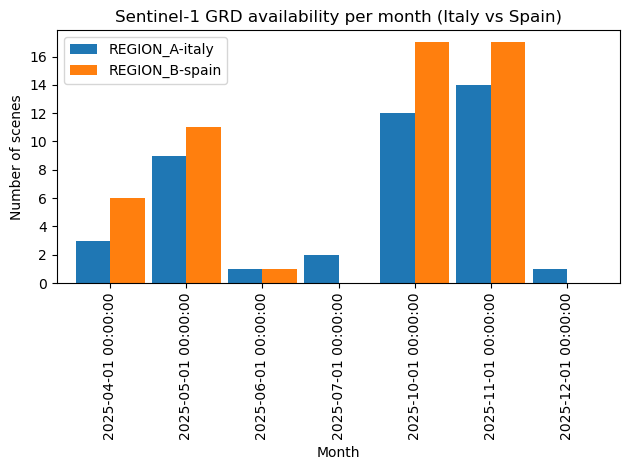


===== Sample inspection: REGION_A-italy =====
Sample item id: S1C_IW_GRDH_1SDV_20251201T171403_20251201T171428_005261_00A71D_A13F
Sample item datetime (UTC): 2025-12-01 17:14:16.009934+00:00

Asset keys in sample item:
 - vh                   | type=application/vnd+zarr | href=https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202512-s01siwgrh-eu/01/products/cpm_v262/S1C_IW_GRDH_1SDV_2...
 - vv                   | type=application/vnd+zarr | href=https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202512-s01siwgrh-eu/01/products/cpm_v262/S1C_IW_GRDH_1SDV_2...
 - product              | type=application/vnd+zarr | href=https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202512-s01siwgrh-eu/01/products/cpm_v262/S1C_IW_GRDH_1SDV_2...
 - noise-vh             | type=application/vnd+zarr | href=https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202512-s01siwgrh-eu/01/products/cpm_v262/S1C_IW_GRDH_1SDV_2...
 - noise-vv             | type=application/vnd+z

In [123]:
import pystac_client
import pandas as pd
import matplotlib.pyplot as plt

STAC_URL = "https://stac.core.eopf.eodc.eu"
COLLECTION_ID = "sentinel-1-l1-grd"
DATE_RANGE = "2020-04-01/2025-12-01"

REGIONS = {
    "REGION_A-italy": [8.34, 45.27, 8.40, 45.31],
    "REGION_B-spain": [0.55, 40.58, 0.90, 40.83],
}

catalog = pystac_client.Client.open(STAC_URL)

def monthly_counts_for_bbox(bbox, date_range):
    search = catalog.search(
        collections=[COLLECTION_ID],
        bbox=bbox,
        datetime=date_range
    )
    items = list(search.items())
    if not items:
        return items, pd.Series(dtype=int)

    dates = [it.datetime for it in items]
    df = pd.DataFrame({"date": pd.to_datetime(dates, utc=True)})
    # group by month (PeriodIndex), then convert to Timestamp later for plotting/merging
    monthly = df.groupby(df["date"].dt.to_period("M")).size().sort_index()
    return items, monthly

all_monthlies = {}
all_items = {}

print("--- Searching Sentinel-1 (GRD) on EOPF STAC ---")
for name, bbox in REGIONS.items():
    print(f"\n[{name}] bbox={bbox}  datetime={DATE_RANGE}")
    items, monthly = monthly_counts_for_bbox(bbox, DATE_RANGE)

    all_items[name] = items
    all_monthlies[name] = monthly

    print(f"Total items found: {len(items)}")
    if len(items) == 0:
        print("No items found for this region.")
    else:
        print("Items per month (head):")
        print(monthly.head(12))

# ---- combine into one table aligned by month ----
# Convert each Series' PeriodIndex to TimestampIndex so we can align across regions
aligned = []
for name, s in all_monthlies.items():
    if len(s) == 0:
        aligned.append(pd.Series(name=name, dtype=int))
    else:
        s2 = s.copy()
        s2.index = s2.index.to_timestamp()  # Period -> Timestamp
        s2.name = name
        aligned.append(s2)

counts_df = pd.concat(aligned, axis=1).fillna(0).astype(int)
counts_df = counts_df.sort_index()

print("\n--- Combined monthly counts (tail) ---")
print(counts_df.tail(12))

# ---- one bar chart for both regions ----
plt.figure(figsize=(14, 6))
counts_df.plot(kind="bar", width=0.9)  # grouped bars per month for both regions
plt.title("Sentinel-1 GRD availability per month (Italy vs Spain)")
plt.xlabel("Month")
plt.ylabel("Number of scenes")
plt.tight_layout()
plt.show()

# ---- inspect assets (one sample per region) ----
for name, items in all_items.items():
    if not items:
        continue

    sample = items[0]
    print(f"\n===== Sample inspection: {name} =====")
    print("Sample item id:", sample.id)
    print("Sample item datetime (UTC):", sample.datetime)

    print("\nAsset keys in sample item:")
    for k, a in sample.assets.items():
        mt = a.media_type if a.media_type else "None"
        href = a.href if a.href else ""
        print(f" - {k:20s} | type={mt} | href={href[:120]}...")

    zarr_like = [
        (k, a.href) for k, a in sample.assets.items()
        if ((a.media_type and "zarr" in a.media_type.lower()) or (a.href and a.href.lower().endswith(".zarr")))
    ]
    print("\nZarr-like assets detected:" if zarr_like else "\nNo obvious zarr-like assets detected in sample.")
    for k, href in zarr_like:
        print(f" - {k}: {href}")

--- Searching Sentinel-3 (GRD) on EOPF STAC ---

[REGION_A-italy] bbox=[8.34, 45.27, 8.4, 45.31]  datetime=2020-04-01/2025-12-01
Total items found: 311
Items per month (head):
date
2025-04      4
2025-05     10
2025-06     13
2025-09      9
2025-10     96
2025-11    173
2025-12      6
Freq: M, dtype: int64

[REGION_B-spain] bbox=[0.55, 40.58, 0.9, 40.83]  datetime=2020-04-01/2025-12-01
Total items found: 327
Items per month (head):
date
2025-04      2
2025-05     11
2025-06     18
2025-09     11
2025-10    104
2025-11    173
2025-12      8
Freq: M, dtype: int64

--- Combined monthly counts (tail) ---
            REGION_A-italy  REGION_B-spain
date                                      
2025-04-01               4               2
2025-05-01              10              11
2025-06-01              13              18
2025-09-01               9              11
2025-10-01              96             104
2025-11-01             173             173
2025-12-01               6               8


<Figure size 1400x600 with 0 Axes>

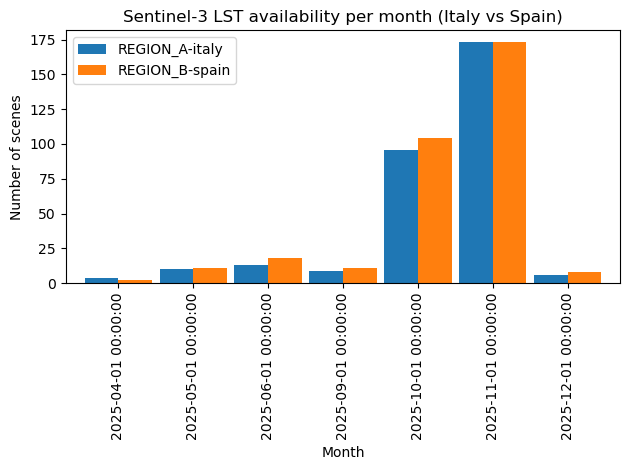


===== Sample inspection: REGION_A-italy =====
Sample item id: S3A_SL_2_LST____20251201T210614_20251201T210914_20251203T084025_0179_133_200_0720_PS1_O_NT_004
Sample item datetime (UTC): 2025-12-01 21:07:44.165672+00:00

Asset keys in sample item:
 - lst                  | type=application/vnd+zarr | href=https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202512-s03slslst-eu/01/products/cpm_v262/S3A_SL_2_LST____20...
 - product              | type=application/vnd+zarr | href=https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202512-s03slslst-eu/01/products/cpm_v262/S3A_SL_2_LST____20...
 - zipped_product       | type=application/zip | href=https://download.user.eopf.eodc.eu/zip/collections/sentinel-3-slstr-l2-lst/items/S3A_SL_2_LST____20251201T210614_2025120...
 - product_metadata     | type=application/json | href=https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202512-s03slslst-eu/01/products/cpm_v262/S3A_SL_2_LST____20...

Zarr-like assets detected:
 -

In [124]:
import pystac_client
import pandas as pd
import matplotlib.pyplot as plt

STAC_URL = "https://stac.core.eopf.eodc.eu"
COLLECTION_ID = "sentinel-3-slstr-l2-lst"
DATE_RANGE = "2020-04-01/2025-12-01"

REGIONS = {
    "REGION_A-italy": [8.34, 45.27, 8.40, 45.31],
    "REGION_B-spain": [0.55, 40.58, 0.90, 40.83],
}

catalog = pystac_client.Client.open(STAC_URL)

def monthly_counts_for_bbox(bbox, date_range):
    search = catalog.search(
        collections=[COLLECTION_ID],
        bbox=bbox,
        datetime=date_range
    )
    items = list(search.items())
    if not items:
        return items, pd.Series(dtype=int)

    dates = [it.datetime for it in items]
    df = pd.DataFrame({"date": pd.to_datetime(dates, utc=True)})
    # group by month (PeriodIndex), then convert to Timestamp later for plotting/merging
    monthly = df.groupby(df["date"].dt.to_period("M")).size().sort_index()
    return items, monthly

all_monthlies = {}
all_items = {}

print("--- Searching Sentinel-3 (GRD) on EOPF STAC ---")
for name, bbox in REGIONS.items():
    print(f"\n[{name}] bbox={bbox}  datetime={DATE_RANGE}")
    items, monthly = monthly_counts_for_bbox(bbox, DATE_RANGE)

    all_items[name] = items
    all_monthlies[name] = monthly

    print(f"Total items found: {len(items)}")
    if len(items) == 0:
        print("No items found for this region.")
    else:
        print("Items per month (head):")
        print(monthly.head(12))

# ---- combine into one table aligned by month ----
# Convert each Series' PeriodIndex to TimestampIndex so we can align across regions
aligned = []
for name, s in all_monthlies.items():
    if len(s) == 0:
        aligned.append(pd.Series(name=name, dtype=int))
    else:
        s2 = s.copy()
        s2.index = s2.index.to_timestamp()  # Period -> Timestamp
        s2.name = name
        aligned.append(s2)

counts_df = pd.concat(aligned, axis=1).fillna(0).astype(int)
counts_df = counts_df.sort_index()

print("\n--- Combined monthly counts (tail) ---")
print(counts_df.tail(12))

# ---- one bar chart for both regions ----
plt.figure(figsize=(14, 6))
counts_df.plot(kind="bar", width=0.9)  # grouped bars per month for both regions
plt.title("Sentinel-3 LST availability per month (Italy vs Spain)")
plt.xlabel("Month")
plt.ylabel("Number of scenes")
plt.tight_layout()
plt.show()

# ---- inspect assets (one sample per region) ----
for name, items in all_items.items():
    if not items:
        continue

    sample = items[0]
    print(f"\n===== Sample inspection: {name} =====")
    print("Sample item id:", sample.id)
    print("Sample item datetime (UTC):", sample.datetime)

    print("\nAsset keys in sample item:")
    for k, a in sample.assets.items():
        mt = a.media_type if a.media_type else "None"
        href = a.href if a.href else ""
        print(f" - {k:20s} | type={mt} | href={href[:120]}...")

    zarr_like = [
        (k, a.href) for k, a in sample.assets.items()
        if ((a.media_type and "zarr" in a.media_type.lower()) or (a.href and a.href.lower().endswith(".zarr")))
    ]
    print("\nZarr-like assets detected:" if zarr_like else "\nNo obvious zarr-like assets detected in sample.")
    for k, href in zarr_like:
        print(f" - {k}: {href}")

### =============================================================
### Step 7: Time-Series Metric Extraction (The Results)

Now we load the `Zarr` data cubes we saved in Step 5 and plot them on a timeline. By putting Region A (Favorable) and Region B (Stressed) on the same graph, we can visually compare their growing seasons. 

*Note: You might see gaps or straight lines connecting dots. Because we removed clouds in Step 5, some weeks have no optical data. The code automatically connects the dots (interpolates) to show the general trend.*

**Expected Output:** Time-series line charts showing the phenological (growth) cycle of the rice crops across the year.
### =============================================================

In [125]:
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pystac_client import Client

# Use the regions from earlier
REGION_A_BBOX = [8.34, 45.27, 8.40, 45.31]  # Vercelli, Italy
REGION_B_BBOX = [9.022, 45.161, 9.055, 45.182]  # Pavia, Italy

# Date range for Sentinel-1 data
S1_DATE_RANGE = "2024-04-01/2025-12-01"

STAC_URL = "https://stac.core.eopf.eodc.eu"
COLLECTION_ID = "sentinel-1-l1-grd"

print("Fetching Sentinel-1 GRD data for Region A and Region B...")
print("=" * 60)

Fetching Sentinel-1 GRD data for Region A and Region B...


In [126]:
def get_s1_vv_mean_odc(bbox, date_range, region_name):
    """
    Fetch Sentinel-1 GRD data using odc.stac and extract mean VV backscatter values
    """
    catalog = Client.open(STAC_URL)
    
    search = catalog.search(
        collections=[COLLECTION_ID],
        bbox=bbox,
        datetime=date_range
    )
    
    items = list(search.items())
    print(f"\n[{region_name}]")
    print(f"  Found {len(items)} Sentinel-1 scenes")
    
    if len(items) == 0:
        print(f"  No data found for {region_name}")
        return None
    
    # Check assets in first item
    sample = items[0]
    print(f"  Available assets: {list(sample.assets.keys())}")
    
    try:
        # Try using odc.stac to load the data
        print(f"  Attempting to load VV band using odc.stac...")
        ds = odc.stac.load(
            items,
            bands=["vv"],
            bbox=bbox,
            resolution=10,  # 10m resolution for Sentinel-1
            chunks={"x": 512, "y": 512, "time": 1},
            groupby="solar_day"
        )
        
        print(f"  Successfully loaded dataset")
        print(f"  Dataset variables: {list(ds.data_vars)}")
        print(f"  Dataset shape: {ds.dims}")
        
        # Extract VV data and compute spatial mean for each time step
        vv_data = ds.vv.mean(dim=["x", "y"], skipna=True).compute()
        
        # Create DataFrame
        df = pd.DataFrame({
            'date': vv_data.time.values,
            'vv_mean': vv_data.values
        })
        df = df.sort_values('date')
        
        # Remove NaN values
        df = df.dropna()
        
        print(f"  Successfully processed {len(df)} scenes")
        if len(df) > 0:
            print(f"  Mean VV backscatter: {df['vv_mean'].mean():.2f}")
        
        return df
        
    except Exception as e:
        print(f"  Error loading with odc.stac: {str(e)[:200]}")
        return None

# Process both regions
print("\nProcessing Region A (Vercelli, Italy)...")
df_region_a = get_s1_vv_mean_odc(REGION_A_BBOX, S1_DATE_RANGE, "Region A")

print("\nProcessing Region B (Pavia, Italy)...")
df_region_b = get_s1_vv_mean_odc(REGION_B_BBOX, S1_DATE_RANGE, "Region B")


Processing Region A (Vercelli, Italy)...

[Region A]
  Found 42 Sentinel-1 scenes
  Available assets: ['vh', 'vv', 'product', 'noise-vh', 'noise-vv', 'calibration-vh', 'calibration-vv', 'zipped_product', 'product_metadata']
  Attempting to load VV band using odc.stac...
  Error loading with odc.stac: No such band/alias: vv

Processing Region B (Pavia, Italy)...

[Region B]
  Found 60 Sentinel-1 scenes
  Available assets: ['vh', 'vv', 'product', 'noise-vh', 'noise-vv', 'calibration-vh', 'calibration-vv', 'zipped_product', 'product_metadata']
  Attempting to load VV band using odc.stac...
  Error loading with odc.stac: No such band/alias: vv


In [127]:
# Plot the VV backscatter time series for both regions
if df_region_a is not None and df_region_b is not None:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Plot Region A
    ax.plot(df_region_a['date'], df_region_a['vv_mean'], 
            marker='o', linewidth=2.5, markersize=8,
            label='Region A (Vercelli, Italy)', color='#3498db')
    
    # Plot Region B
    ax.plot(df_region_b['date'], df_region_b['vv_mean'],
            marker='s', linewidth=2.5, markersize=8,
            label='Region B (Pavia, Italy)', color='#e67e22')
    
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('VV Backscatter (dB)', fontsize=12, fontweight='bold')
    ax.set_title('Sentinel-1 VV Backscatter: Region A vs Region B', 
                 fontsize=14, fontweight='bold', pad=15)
    ax.legend(loc='best', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\n" + "=" * 60)
    print("VV Backscatter Statistics:")
    print("=" * 60)
    print(f"\nRegion A (Vercelli, Italy):")
    print(f"  Mean VV: {df_region_a['vv_mean'].mean():.2f} dB")
    print(f"  Std Dev: {df_region_a['vv_mean'].std():.2f} dB")
    print(f"  Min VV: {df_region_a['vv_mean'].min():.2f} dB")
    print(f"  Max VV: {df_region_a['vv_mean'].max():.2f} dB")
    
    print(f"\nRegion B (Pavia, Italy):")
    print(f"  Mean VV: {df_region_b['vv_mean'].mean():.2f} dB")
    print(f"  Std Dev: {df_region_b['vv_mean'].std():.2f} dB")
    print(f"  Min VV: {df_region_b['vv_mean'].min():.2f} dB")
    print(f"  Max VV: {df_region_b['vv_mean'].max():.2f} dB")
    
    print(f"\nDifference (Region A - Region B):")
    print(f"  Mean difference: {(df_region_a['vv_mean'].mean() - df_region_b['vv_mean'].mean()):.2f} dB")
else:
    print("\n⚠️ Could not process VV data for one or both regions")


⚠️ Could not process VV data for one or both regions


### Step 8: Comprehensive Availability Coverage
Compute absolute data coverage counts across sensors. This produces graphical analytics outlining the feasibility of a multi-sensor yield prediction model.

**Expected Output:** Deep heatmap visualizers, comparative mission bar-log charts, and terminal output describing raw STAC item saturation.

In [128]:
import pystac_client
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

# Set up the STAC catalogs
EOPF_STAC_URL = "https://stac.core.eopf.eodc.eu"
AWS_STAC_URL = "https://earth-search.aws.element84.com/v1"

# Collections to query
COLLECTIONS = {
    "Sentinel-1 GRD": ("sentinel-1-l1-grd", EOPF_STAC_URL),
    "Sentinel-2 L2A": ("sentinel-2-l2a", AWS_STAC_URL),
    "Sentinel-3 LST": ("sentinel-3-slstr-l2-lst", EOPF_STAC_URL)
}

# Regions
REGIONS = {
    "Region A (Vercelli, Italy)": [8.34, 45.27, 8.40, 45.31],
    "Region B (Pavia, Italy)": [9.022, 45.161, 9.055, 45.182]
}

# Date range for comprehensive analysis
DATE_RANGE = "2024-01-01/2025-12-31"

print("Fetching data availability for all Sentinel missions...")
print("=" * 70)

Fetching data availability for all Sentinel missions...


In [129]:
def get_monthly_counts(collection_name, collection_id, stac_url, bbox, date_range):
    """
    Get monthly scene counts for a specific collection and region
    """
    try:
        catalog = pystac_client.Client.open(stac_url)
        
        # Add cloud cover filter for Sentinel-2
        if "sentinel-2" in collection_id.lower():
            search = catalog.search(
                collections=[collection_id],
                bbox=bbox,
                datetime=date_range,
                query={"eo:cloud_cover": {"lt": 50}}
            )
        else:
            search = catalog.search(
                collections=[collection_id],
                bbox=bbox,
                datetime=date_range
            )
        
        items = list(search.items())
        
        if not items:
            return pd.Series(dtype=int)
        
        # Extract dates
        dates = [item.datetime for item in items]
        df = pd.DataFrame({"date": pd.to_datetime(dates, utc=True)})
        
        # Group by year-month
        monthly = df.groupby(df["date"].dt.to_period("M")).size().sort_index()
        
        return monthly
    
    except Exception as e:
        print(f"  Error fetching {collection_name}: {str(e)[:100]}")
        return pd.Series(dtype=int)

# Collect data for all combinations
all_data = {}

for region_name, bbox in REGIONS.items():
    print(f"\n{region_name}")
    print("-" * 70)
    
    region_data = {}
    
    for collection_name, (collection_id, stac_url) in COLLECTIONS.items():
        print(f"  Fetching {collection_name}...", end=" ")
        
        monthly = get_monthly_counts(collection_name, collection_id, stac_url, bbox, DATE_RANGE)
        
        if len(monthly) > 0:
            print(f"✓ {len(monthly)} months with data, {monthly.sum()} total scenes")
            region_data[collection_name] = monthly
        else:
            print("✗ No data found")
            region_data[collection_name] = pd.Series(dtype=int)
    
    all_data[region_name] = region_data

print("\n" + "=" * 70)
print("Data collection complete!")


Region A (Vercelli, Italy)
----------------------------------------------------------------------
  Fetching Sentinel-1 GRD... ✓ 7 months with data, 55 total scenes
  Fetching Sentinel-2 L2A... ✓ 24 months with data, 149 total scenes
  Fetching Sentinel-3 LST... ✓ 7 months with data, 468 total scenes

Region B (Pavia, Italy)
----------------------------------------------------------------------
  Fetching Sentinel-1 GRD... ✓ 7 months with data, 78 total scenes
  Fetching Sentinel-2 L2A... ✓ 24 months with data, 146 total scenes
  Fetching Sentinel-3 LST... ✓ 7 months with data, 465 total scenes

Data collection complete!


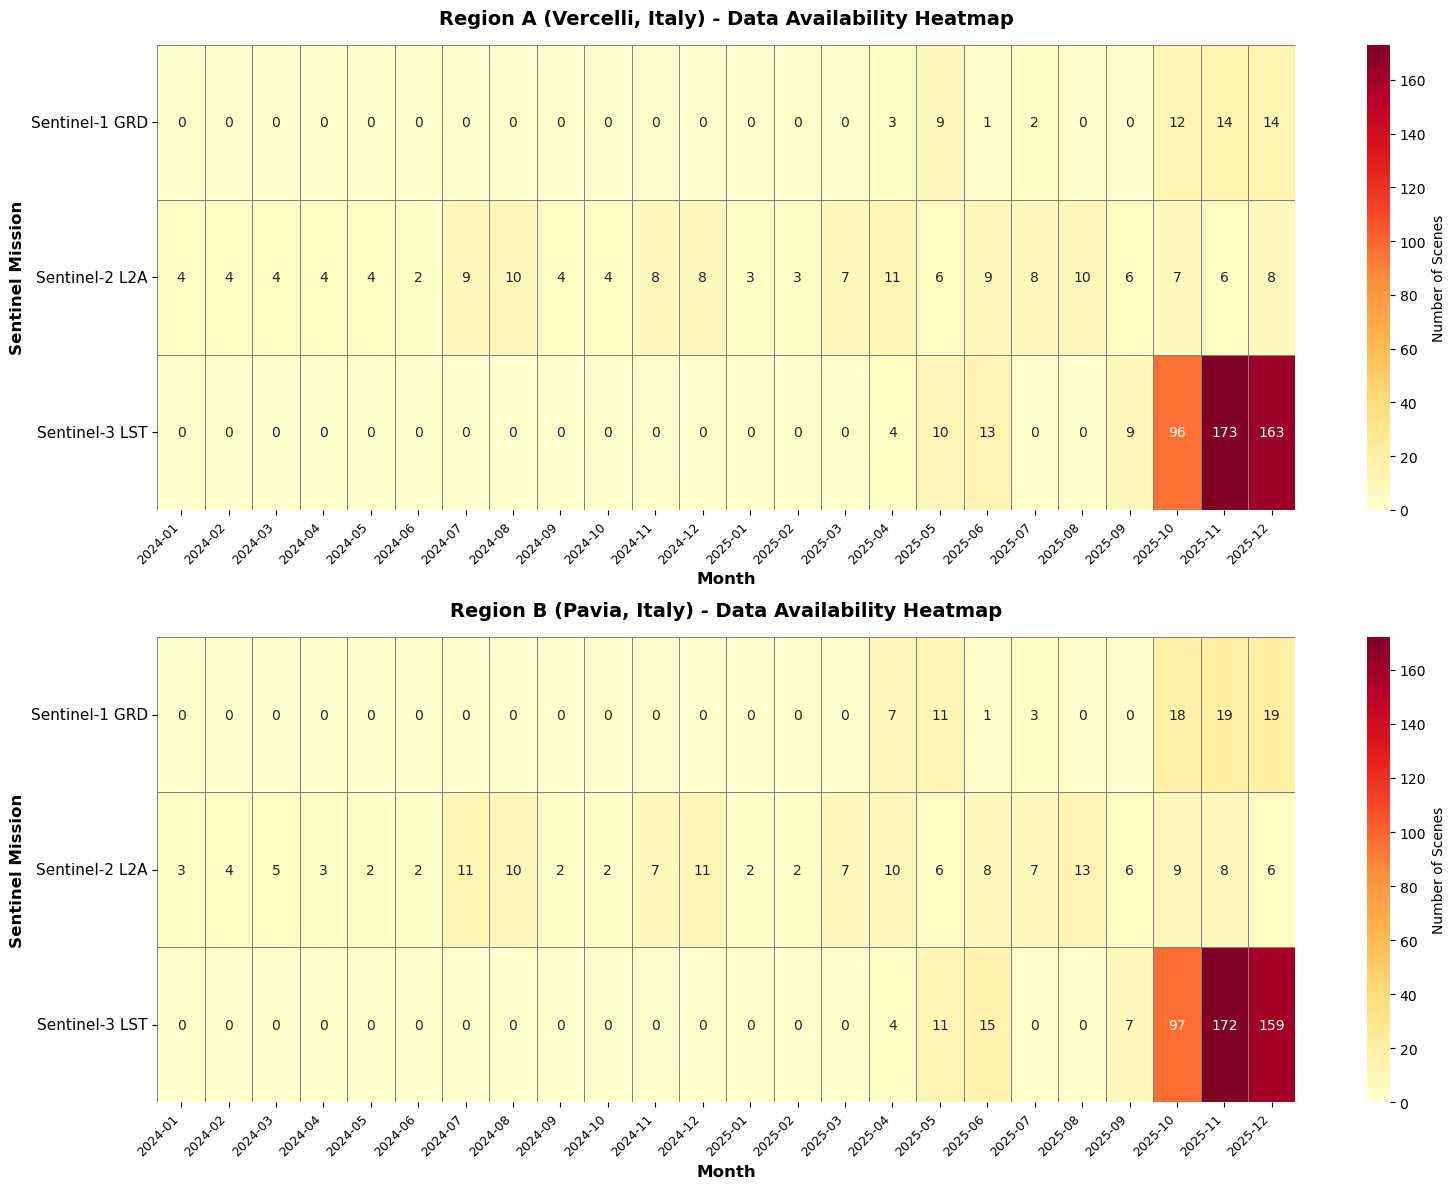


SUMMARY STATISTICS


In [130]:
# Create comprehensive heatmap visualization
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

for idx, (region_name, region_data) in enumerate(all_data.items()):
    ax = axes[idx]
    
    # Prepare data for heatmap
    # Get all unique months across all collections
    all_months = set()
    for collection_name, monthly in region_data.items():
        if len(monthly) > 0:
            all_months.update(monthly.index)
    
    if not all_months:
        ax.text(0.5, 0.5, f'No data available for {region_name}', 
                ha='center', va='center', fontsize=14)
        ax.set_title(region_name, fontsize=14, fontweight='bold', pad=15)
        continue
    
    # Sort months
    all_months = sorted(list(all_months))
    
    # Create matrix for heatmap
    heatmap_data = []
    collection_names = []
    
    for collection_name in ["Sentinel-1 GRD", "Sentinel-2 L2A", "Sentinel-3 LST"]:
        if collection_name in region_data:
            monthly = region_data[collection_name]
            row = []
            for month in all_months:
                if month in monthly.index:
                    row.append(monthly[month])
                else:
                    row.append(0)
            heatmap_data.append(row)
            collection_names.append(collection_name)
    
    # Convert to numpy array
    heatmap_array = np.array(heatmap_data)
    
    # Create heatmap
    sns.heatmap(heatmap_array, 
                ax=ax,
                cmap='YlOrRd',
                annot=True,
                fmt='d',
                cbar_kws={'label': 'Number of Scenes'},
                linewidths=0.5,
                linecolor='gray')
    
    # Set labels
    ax.set_yticklabels(collection_names, rotation=0, fontsize=11)
    ax.set_xticklabels([str(m) for m in all_months], rotation=45, ha='right', fontsize=9)
    ax.set_xlabel('Month', fontsize=12, fontweight='bold')
    ax.set_ylabel('Sentinel Mission', fontsize=12, fontweight='bold')
    ax.set_title(f'{region_name} - Data Availability Heatmap', 
                 fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("SUMMARY STATISTICS")
print("=" * 70)

In [131]:
# Print detailed statistics
for region_name, region_data in all_data.items():
    print(f"\n{region_name}")
    print("-" * 70)
    
    for collection_name in ["Sentinel-1 GRD", "Sentinel-2 L2A", "Sentinel-3 LST"]:
        if collection_name in region_data:
            monthly = region_data[collection_name]
            
            if len(monthly) > 0:
                total_scenes = monthly.sum()
                avg_per_month = monthly.mean()
                max_month = monthly.idxmax()
                max_scenes = monthly.max()
                min_scenes = monthly.min()
                
                print(f"\n  {collection_name}:")
                print(f"    Total scenes: {total_scenes}")
                print(f"    Average per month: {avg_per_month:.1f}")
                print(f"    Max scenes in a month: {max_scenes} ({max_month})")
                print(f"    Min scenes in a month: {min_scenes}")
                print(f"    Months with data: {len(monthly)}")
            else:
                print(f"\n  {collection_name}:")
                print(f"    No data available")


Region A (Vercelli, Italy)
----------------------------------------------------------------------

  Sentinel-1 GRD:
    Total scenes: 55
    Average per month: 7.9
    Max scenes in a month: 14 (2025-11)
    Min scenes in a month: 1
    Months with data: 7

  Sentinel-2 L2A:
    Total scenes: 149
    Average per month: 6.2
    Max scenes in a month: 11 (2025-04)
    Min scenes in a month: 2
    Months with data: 24

  Sentinel-3 LST:
    Total scenes: 468
    Average per month: 66.9
    Max scenes in a month: 173 (2025-11)
    Min scenes in a month: 4
    Months with data: 7

Region B (Pavia, Italy)
----------------------------------------------------------------------

  Sentinel-1 GRD:
    Total scenes: 78
    Average per month: 11.1
    Max scenes in a month: 19 (2025-11)
    Min scenes in a month: 1
    Months with data: 7

  Sentinel-2 L2A:
    Total scenes: 146
    Average per month: 6.1
    Max scenes in a month: 13 (2025-08)
    Min scenes in a month: 2
    Months with data: 

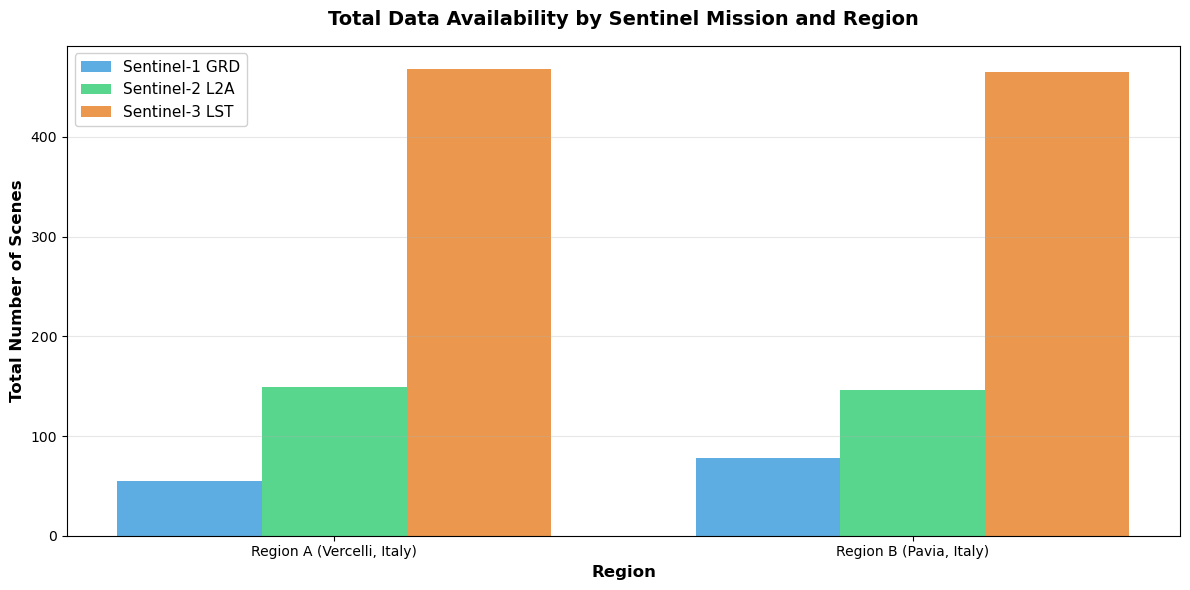


✓ Heatmap analysis complete!


In [132]:
# Create a comparison bar chart showing total scenes by mission and region
fig, ax = plt.subplots(figsize=(12, 6))

regions = list(all_data.keys())
missions = ["Sentinel-1 GRD", "Sentinel-2 L2A", "Sentinel-3 LST"]

# Prepare data
data_for_plot = {mission: [] for mission in missions}

for region_name in regions:
    region_data = all_data[region_name]
    for mission in missions:
        if mission in region_data and len(region_data[mission]) > 0:
            data_for_plot[mission].append(region_data[mission].sum())
        else:
            data_for_plot[mission].append(0)

# Create grouped bar chart
x = np.arange(len(regions))
width = 0.25

colors = ['#3498db', '#2ecc71', '#e67e22']

for i, (mission, color) in enumerate(zip(missions, colors)):
    offset = width * (i - 1)
    ax.bar(x + offset, data_for_plot[mission], width, 
           label=mission, color=color, alpha=0.8)

ax.set_xlabel('Region', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Number of Scenes', fontsize=12, fontweight='bold')
ax.set_title('Total Data Availability by Sentinel Mission and Region', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(regions, fontsize=10)
ax.legend(fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Heatmap analysis complete!")